# Regime-Conditional Models - AAPL Microstructure Prediction

**Objective:** Train separate models for each market regime and validate that regime detection improves prediction accuracy.

**Hypothesis:** Different market regimes (Calm, Volatile, Trending) require different prediction strategies. Training regime-specific models should outperform a single global model.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Best models from notebooks 35, 40, 45, 50
- **Time period:** December 9-13, 2024 (5 trading days)

**Approach:**

- Split data by HMM regime labels (Calm, Volatile, Trending)
- Train separate Random Forest/Gradient Boosting models per regime
- Compare regime-conditional vs. global model performance
- Analyze which features dominate in each regime
- Economic validation through regime-aware trading simulation

**Outputs:**

- Regime-specific models
- Per-regime performance metrics
- Feature importance by regime
- Regime-aware trading results
- Validation that regime detection provides value

**Target Variable:** Next-period mid-price direction (up=1, down=0)


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
from scipy import stats

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)


# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
regime_dir = FIGURES_DIR / "regime_conditional"
regime_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print(" Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {regime_dir}")

 Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/regime_conditional


In [2]:
# %% Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"
END_DATE = "2024-12-13"
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Trading days: 5")

Configuration:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13
  Trading days: 5


## 2. Load Data and Previous Results


In [3]:
# Load features with regimes from notebook 30
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f" Features with regimes: {features_with_regimes.shape}")

# Load previous model results
with open(MODELS_DIR / "random_forest_results.json", "r") as f:
    rf_results = json.load(f)

with open(MODELS_DIR / "gradient_boosting_results.json", "r") as f:
    gb_results = json.load(f)

print("\n Loaded previous results")
print(f"\nRandom Forest (Global Model):")
print(f"  Test Accuracy: {rf_results['rf_tuned']['test_accuracy']:.4f}")
print(f"  Test F1:       {rf_results['rf_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {rf_results['rf_tuned']['test_roc_auc']:.4f}")

print(f"\nGradient Boosting (Global Model):")
print(f"  Test Accuracy: {gb_results['gb_tuned']['test_accuracy']:.4f}")
print(f"  Test F1:       {gb_results['gb_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {gb_results['gb_tuned']['test_roc_auc']:.4f}")

Loading features with regimes...
 Features with regimes: (1365, 94)

 Loaded previous results

Random Forest (Global Model):
  Test Accuracy: 0.6300
  Test F1:       0.6354
  Test ROC-AUC:  0.6945

Gradient Boosting (Global Model):
  Test Accuracy: 0.6447
  Test F1:       0.6473
  Test ROC-AUC:  0.7086


## 3. Prepare Data with Regimes


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(f"No price column found")

print(f"Using price column: {price_col}")

# Create target
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)
features_with_regimes = features_with_regimes[:-1].copy()

# Analyze regime distribution
print("\nRegime distribution:")
regime_counts = features_with_regimes["regime_hmm"].value_counts()
print(regime_counts)
print(f"\nRegime proportions:")
for regime, count in regime_counts.items():
    print(f"  {regime}: {100*count/len(features_with_regimes):.1f}%")

# Target distribution by regime
print("\nTarget distribution by regime:")
for regime in regime_counts.index:
    regime_data = features_with_regimes[features_with_regimes["regime_hmm"] == regime]
    up_pct = 100 * regime_data["target"].sum() / len(regime_data)
    print(f"  {regime}: {up_pct:.1f}% up, {100-up_pct:.1f}% down")

Using price column: agg_mid_price

Regime distribution:
regime_hmm
Trending    526
Calm        519
Volatile    319
Name: count, dtype: int64

Regime proportions:
  Trending: 38.6%
  Calm: 38.0%
  Volatile: 23.4%

Target distribution by regime:
  Trending: 47.3% up, 52.7% down
  Calm: 47.2% up, 52.8% down
  Volatile: 48.6% up, 51.4% down


## 4. Feature Selection


In [5]:
# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X_full = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X_full.columns.tolist()

# Handle missing and infinite values
X_full = X_full.fillna(method="ffill").fillna(method="bfill").fillna(0)
X_full = X_full.replace([np.inf, -np.inf], np.nan).fillna(0)

# Get target and regime
y_full = features_with_regimes["target"].values
regimes_full = features_with_regimes["regime_hmm"].values

print(f" Feature matrix: {X_full.shape}")
print(f" Target vector: {y_full.shape}")
print(f" Regimes: {len(regimes_full)} samples")

 Feature matrix: (1364, 81)
 Target vector: (1364,)
 Regimes: 1364 samples


## 5. Train-Test Split (Preserving Regime Distribution)


In [6]:
# Time-series split (no shuffling)
split_idx = int(len(X_full) * 0.8)

X_train = X_full.iloc[:split_idx]
X_test = X_full.iloc[split_idx:]
y_train = y_full[:split_idx]
y_test = y_full[split_idx:]
regimes_train = regimes_full[:split_idx]
regimes_test = regimes_full[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

print("\nTrain regime distribution:")
train_regime_counts = pd.Series(regimes_train).value_counts()
for regime, count in train_regime_counts.items():
    print(f"  {regime}: {count:,} ({100*count/len(regimes_train):.1f}%)")

print("\nTest regime distribution:")
test_regime_counts = pd.Series(regimes_test).value_counts()
for regime, count in test_regime_counts.items():
    print(f"  {regime}: {count:,} ({100*count/len(regimes_test):.1f}%)")

Train set: 1,091 samples
Test set: 273 samples

Train regime distribution:
  Trending: 403 (36.9%)
  Calm: 398 (36.5%)
  Volatile: 290 (26.6%)

Test regime distribution:
  Trending: 123 (45.1%)
  Calm: 121 (44.3%)
  Volatile: 29 (10.6%)


## 6. Train Global Baseline Models

Train models on all data (regime-agnostic) for comparison


In [7]:
# Train global Random Forest
print("Training global Random Forest...")
rf_global = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)
rf_global.fit(X_train, y_train)
y_test_pred_rf_global = rf_global.predict(X_test)
y_test_proba_rf_global = rf_global.predict_proba(X_test)[:, 1]

print("\nGlobal Random Forest (regime-agnostic):")
print(f"  Test Accuracy: {accuracy_score(y_test, y_test_pred_rf_global):.4f}")
print(f"  Test F1:       {f1_score(y_test, y_test_pred_rf_global):.4f}")
print(f"  Test ROC-AUC:  {roc_auc_score(y_test, y_test_proba_rf_global):.4f}")

# Train global Gradient Boosting
print("\nTraining global Gradient Boosting...")
gb_global = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)
gb_global.fit(X_train, y_train)
y_test_pred_gb_global = gb_global.predict(X_test)
y_test_proba_gb_global = gb_global.predict_proba(X_test)[:, 1]

print("\nGlobal Gradient Boosting (regime-agnostic):")
print(f"  Test Accuracy: {accuracy_score(y_test, y_test_pred_gb_global):.4f}")
print(f"  Test F1:       {f1_score(y_test, y_test_pred_gb_global):.4f}")
print(f"  Test ROC-AUC:  {roc_auc_score(y_test, y_test_proba_gb_global):.4f}")

Training global Random Forest...

Global Random Forest (regime-agnostic):
  Test Accuracy: 0.6447
  Test F1:       0.6394
  Test ROC-AUC:  0.6852

Training global Gradient Boosting...

Global Gradient Boosting (regime-agnostic):
  Test Accuracy: 0.6447
  Test F1:       0.6135
  Test ROC-AUC:  0.7167


## 7. Train Regime-Specific Models

Train separate Random Forest models for each regime


In [8]:
# Train regime-specific models
regime_models_rf = {}
regime_models_gb = {}

# Minimum samples required to train a regime-specific model
MIN_REGIME_SAMPLES = 20

print("=" * 80)
print("TRAINING REGIME-SPECIFIC MODELS")
print("=" * 80)

for regime in train_regime_counts.index:
    # Get regime-specific data
    regime_mask_train = regimes_train == regime
    X_regime = X_train[regime_mask_train]
    y_regime = y_train[regime_mask_train]

    print(f"\n{regime} Regime:")
    print(f"  Training samples: {len(X_regime):,}")

    # Check if we have enough samples and both classes
    n_classes = len(np.unique(y_regime))

    if len(X_regime) < MIN_REGIME_SAMPLES:
        print(
            f"   Skipping - insufficient samples (need at least {MIN_REGIME_SAMPLES})"
        )
        print(f"   Will use global model for {regime} predictions")
        continue

    if n_classes < 2:
        print(f"   Skipping - only {n_classes} class in training data (need 2)")
        print(f"   Will use global model for {regime} predictions")
        continue

    # Train Random Forest for this regime
    rf_regime = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=min(50, len(X_regime) // 5),  # Adjust for small samples
        random_state=42,
        class_weight="balanced",
        n_jobs=-1,
    )
    rf_regime.fit(X_regime, y_regime)
    regime_models_rf[regime] = rf_regime

    # Train Gradient Boosting for this regime
    gb_regime = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    )
    gb_regime.fit(X_regime, y_regime)
    regime_models_gb[regime] = gb_regime

    print(f"   Trained Random Forest for {regime}")
    print(f"   Trained Gradient Boosting for {regime}")

print(f"\n Trained {len(regime_models_rf)} regime-specific model pairs")
if len(regime_models_rf) < len(train_regime_counts):
    print(
        f" Note: {len(train_regime_counts) - len(regime_models_rf)} regime(s) skipped due to insufficient data"
    )
    print(f"   These regimes will use the global model for predictions")

TRAINING REGIME-SPECIFIC MODELS

Trending Regime:
  Training samples: 403
   Trained Random Forest for Trending
   Trained Gradient Boosting for Trending

Calm Regime:
  Training samples: 398
   Trained Random Forest for Calm
   Trained Gradient Boosting for Calm

Volatile Regime:
  Training samples: 290
   Trained Random Forest for Volatile
   Trained Gradient Boosting for Volatile

 Trained 3 regime-specific model pairs


## 8. Regime-Conditional Predictions

Use regime-specific models for predictions based on test regime labels


In [9]:
# Make regime-conditional predictions
y_test_pred_rf_conditional = np.zeros(len(y_test))
y_test_proba_rf_conditional = np.zeros(len(y_test))
y_test_pred_gb_conditional = np.zeros(len(y_test))
y_test_proba_gb_conditional = np.zeros(len(y_test))

print("Making regime-conditional predictions...")

for regime in test_regime_counts.index:
    # Get test samples for this regime
    regime_mask_test = regimes_test == regime
    X_regime_test = X_test[regime_mask_test]

    # Random Forest predictions
    if regime in regime_models_rf:
        # Use regime-specific model
        y_test_pred_rf_conditional[regime_mask_test] = regime_models_rf[regime].predict(
            X_regime_test
        )
        y_test_proba_rf_conditional[regime_mask_test] = regime_models_rf[
            regime
        ].predict_proba(X_regime_test)[:, 1]
        print(
            f"  ✓ Predicted {regime_mask_test.sum():,} {regime} samples (regime-specific model)"
        )
    else:
        # Fall back to global model
        y_test_pred_rf_conditional[regime_mask_test] = rf_global.predict(X_regime_test)
        y_test_proba_rf_conditional[regime_mask_test] = rf_global.predict_proba(
            X_regime_test
        )[:, 1]
        print(
            f"  ✓ Predicted {regime_mask_test.sum():,} {regime} samples (using global model - no regime-specific model)"
        )

    # Gradient Boosting predictions
    if regime in regime_models_gb:
        # Use regime-specific model
        y_test_pred_gb_conditional[regime_mask_test] = regime_models_gb[regime].predict(
            X_regime_test
        )
        y_test_proba_gb_conditional[regime_mask_test] = regime_models_gb[
            regime
        ].predict_proba(X_regime_test)[:, 1]
    else:
        # Fall back to global model
        y_test_pred_gb_conditional[regime_mask_test] = gb_global.predict(X_regime_test)
        y_test_proba_gb_conditional[regime_mask_test] = gb_global.predict_proba(
            X_regime_test
        )[:, 1]

print("\n✓ Regime-conditional predictions complete")

Making regime-conditional predictions...
  ✓ Predicted 123 Trending samples (regime-specific model)
  ✓ Predicted 121 Calm samples (regime-specific model)
  ✓ Predicted 29 Volatile samples (regime-specific model)

✓ Regime-conditional predictions complete


## 9. Compare Global vs. Regime-Conditional Performance


In [10]:
# Calculate metrics
print("=" * 80)
print("GLOBAL vs. REGIME-CONDITIONAL COMPARISON")
print("=" * 80)

# Random Forest comparison
print("\nRANDOM FOREST:")
print("\nGlobal Model (regime-agnostic):")
rf_global_acc = accuracy_score(y_test, y_test_pred_rf_global)
rf_global_f1 = f1_score(y_test, y_test_pred_rf_global)
rf_global_auc = roc_auc_score(y_test, y_test_proba_rf_global)
print(f"  Accuracy: {rf_global_acc:.4f}")
print(f"  F1-score: {rf_global_f1:.4f}")
print(f"  ROC-AUC:  {rf_global_auc:.4f}")

print("\nRegime-Conditional Model:")
rf_conditional_acc = accuracy_score(y_test, y_test_pred_rf_conditional)
rf_conditional_f1 = f1_score(y_test, y_test_pred_rf_conditional)
rf_conditional_auc = roc_auc_score(y_test, y_test_proba_rf_conditional)
print(f"  Accuracy: {rf_conditional_acc:.4f}")
print(f"  F1-score: {rf_conditional_f1:.4f}")
print(f"  ROC-AUC:  {rf_conditional_auc:.4f}")

print("\nIMPROVEMENT (Regime-Conditional over Global):")
rf_acc_improvement = rf_conditional_acc - rf_global_acc
rf_f1_improvement = rf_conditional_f1 - rf_global_f1
rf_auc_improvement = rf_conditional_auc - rf_global_auc
print(
    f"  Accuracy: {rf_acc_improvement:+.4f} ({100*rf_acc_improvement/rf_global_acc:+.1f}%)"
)
print(
    f"  F1-score: {rf_f1_improvement:+.4f} ({100*rf_f1_improvement/rf_global_f1:+.1f}%)"
)
print(
    f"  ROC-AUC:  {rf_auc_improvement:+.4f} ({100*rf_auc_improvement/rf_global_auc:+.1f}%)"
)

# Gradient Boosting comparison
print("\n" + "=" * 80)
print("GRADIENT BOOSTING:")
print("\nGlobal Model (regime-agnostic):")
gb_global_acc = accuracy_score(y_test, y_test_pred_gb_global)
gb_global_f1 = f1_score(y_test, y_test_pred_gb_global)
gb_global_auc = roc_auc_score(y_test, y_test_proba_gb_global)
print(f"  Accuracy: {gb_global_acc:.4f}")
print(f"  F1-score: {gb_global_f1:.4f}")
print(f"  ROC-AUC:  {gb_global_auc:.4f}")

print("\nRegime-Conditional Model:")
gb_conditional_acc = accuracy_score(y_test, y_test_pred_gb_conditional)
gb_conditional_f1 = f1_score(y_test, y_test_pred_gb_conditional)
gb_conditional_auc = roc_auc_score(y_test, y_test_proba_gb_conditional)
print(f"  Accuracy: {gb_conditional_acc:.4f}")
print(f"  F1-score: {gb_conditional_f1:.4f}")
print(f"  ROC-AUC:  {gb_conditional_auc:.4f}")

print("\nIMPROVEMENT (Regime-Conditional over Global):")
gb_acc_improvement = gb_conditional_acc - gb_global_acc
gb_f1_improvement = gb_conditional_f1 - gb_global_f1
gb_auc_improvement = gb_conditional_auc - gb_global_auc
print(
    f"  Accuracy: {gb_acc_improvement:+.4f} ({100*gb_acc_improvement/gb_global_acc:+.1f}%)"
)
print(
    f"  F1-score: {gb_f1_improvement:+.4f} ({100*gb_f1_improvement/gb_global_f1:+.1f}%)"
)
print(
    f"  ROC-AUC:  {gb_auc_improvement:+.4f} ({100*gb_auc_improvement/gb_global_auc:+.1f}%)"
)

GLOBAL vs. REGIME-CONDITIONAL COMPARISON

RANDOM FOREST:

Global Model (regime-agnostic):
  Accuracy: 0.6447
  F1-score: 0.6394
  ROC-AUC:  0.6852

Regime-Conditional Model:
  Accuracy: 0.6117
  F1-score: 0.6159
  ROC-AUC:  0.6741

IMPROVEMENT (Regime-Conditional over Global):
  Accuracy: -0.0330 (-5.1%)
  F1-score: -0.0235 (-3.7%)
  ROC-AUC:  -0.0111 (-1.6%)

GRADIENT BOOSTING:

Global Model (regime-agnostic):
  Accuracy: 0.6447
  F1-score: 0.6135
  ROC-AUC:  0.7167

Regime-Conditional Model:
  Accuracy: 0.6190
  F1-score: 0.6061
  ROC-AUC:  0.6677

IMPROVEMENT (Regime-Conditional over Global):
  Accuracy: -0.0256 (-4.0%)
  F1-score: -0.0075 (-1.2%)
  ROC-AUC:  -0.0491 (-6.8%)


## 10. Per-Regime Performance Analysis


In [11]:
# Analyze performance within each regime
print("=" * 80)
print("PER-REGIME PERFORMANCE ANALYSIS")
print("=" * 80)

regime_performance = []

for regime in test_regime_counts.index:
    regime_mask = regimes_test == regime
    y_regime = y_test[regime_mask]

    # Global model performance on this regime
    y_pred_global_rf = y_test_pred_rf_global[regime_mask]
    y_pred_global_gb = y_test_pred_gb_global[regime_mask]

    # Regime-specific model performance
    y_pred_conditional_rf = y_test_pred_rf_conditional[regime_mask]
    y_pred_conditional_gb = y_test_pred_gb_conditional[regime_mask]

    print(f"\n{regime} Regime ({regime_mask.sum():,} samples):")
    print("\n  Random Forest:")
    global_acc_rf = accuracy_score(y_regime, y_pred_global_rf)
    conditional_acc_rf = accuracy_score(y_regime, y_pred_conditional_rf)
    print(f"    Global:      {global_acc_rf:.4f}")
    print(
        f"    Conditional: {conditional_acc_rf:.4f} ({conditional_acc_rf - global_acc_rf:+.4f})"
    )

    print("\n  Gradient Boosting:")
    global_acc_gb = accuracy_score(y_regime, y_pred_global_gb)
    conditional_acc_gb = accuracy_score(y_regime, y_pred_conditional_gb)
    print(f"    Global:      {global_acc_gb:.4f}")
    print(
        f"    Conditional: {conditional_acc_gb:.4f} ({conditional_acc_gb - global_acc_gb:+.4f})"
    )

    regime_performance.append(
        {
            "regime": regime,
            "n_samples": int(regime_mask.sum()),
            "rf_global_acc": float(global_acc_rf),
            "rf_conditional_acc": float(conditional_acc_rf),
            "rf_improvement": float(conditional_acc_rf - global_acc_rf),
            "gb_global_acc": float(global_acc_gb),
            "gb_conditional_acc": float(conditional_acc_gb),
            "gb_improvement": float(conditional_acc_gb - global_acc_gb),
        }
    )

regime_performance_df = pd.DataFrame(regime_performance)

PER-REGIME PERFORMANCE ANALYSIS

Trending Regime (123 samples):

  Random Forest:
    Global:      0.6667
    Conditional: 0.6016 (-0.0650)

  Gradient Boosting:
    Global:      0.6260
    Conditional: 0.6179 (-0.0081)

Calm Regime (121 samples):

  Random Forest:
    Global:      0.6364
    Conditional: 0.6198 (-0.0165)

  Gradient Boosting:
    Global:      0.6694
    Conditional: 0.6446 (-0.0248)

Volatile Regime (29 samples):

  Random Forest:
    Global:      0.5862
    Conditional: 0.6207 (+0.0345)

  Gradient Boosting:
    Global:      0.6207
    Conditional: 0.5172 (-0.1034)


## 11. Visualize Performance Comparison


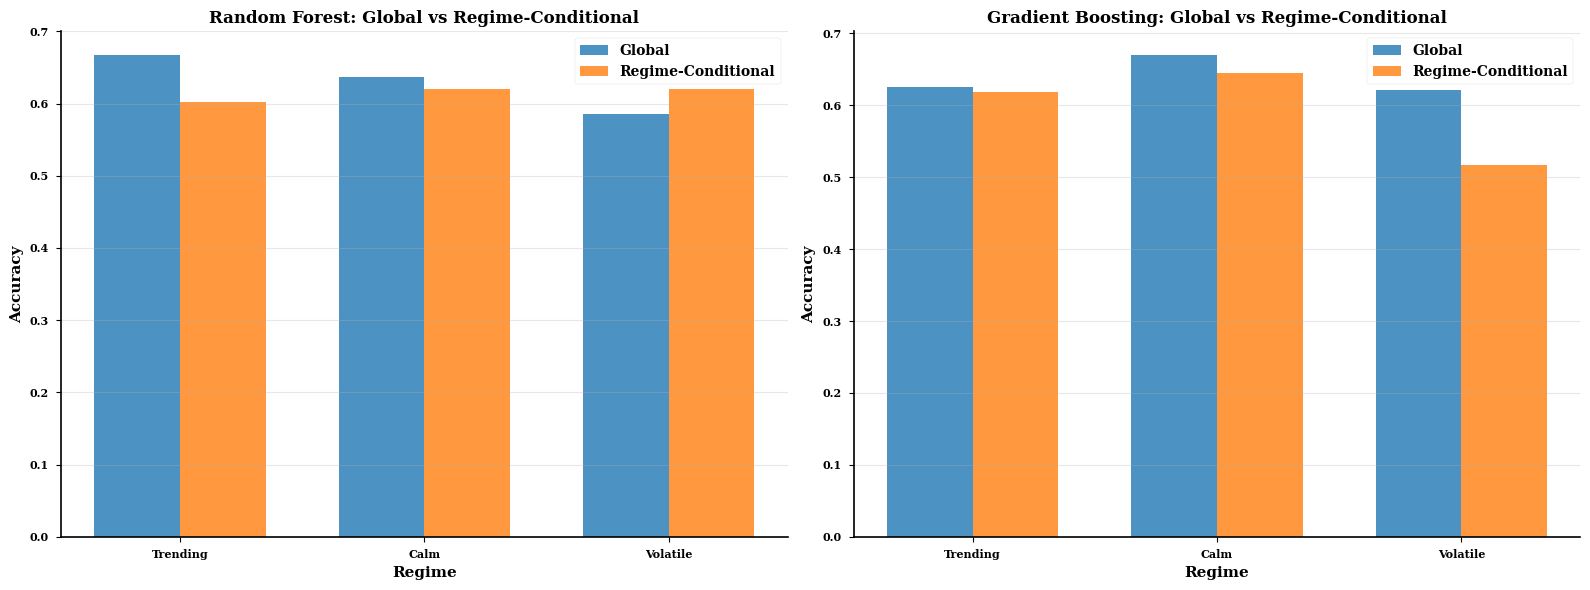


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/regime_conditional/regime_performance_comparison.png


In [12]:
# Plot performance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Random Forest - Global vs Conditional by Regime
x = np.arange(len(regime_performance_df))
width = 0.35

axes[0].bar(
    x - width / 2,
    regime_performance_df["rf_global_acc"],
    width,
    label="Global",
    alpha=0.8,
)
axes[0].bar(
    x + width / 2,
    regime_performance_df["rf_conditional_acc"],
    width,
    label="Regime-Conditional",
    alpha=0.8,
)
axes[0].set_xlabel("Regime", fontsize=11)
axes[0].set_ylabel("Accuracy", fontsize=11)
axes[0].set_title(
    "Random Forest: Global vs Regime-Conditional", fontsize=12, fontweight="bold"
)
axes[0].set_xticks(x)
axes[0].set_xticklabels(regime_performance_df["regime"])
axes[0].legend(fontsize=10)
axes[0].grid(axis="y", alpha=0.3)

# Plot 2: Gradient Boosting - Global vs Conditional by Regime
axes[1].bar(
    x - width / 2,
    regime_performance_df["gb_global_acc"],
    width,
    label="Global",
    alpha=0.8,
)
axes[1].bar(
    x + width / 2,
    regime_performance_df["gb_conditional_acc"],
    width,
    label="Regime-Conditional",
    alpha=0.8,
)
axes[1].set_xlabel("Regime", fontsize=11)
axes[1].set_ylabel("Accuracy", fontsize=11)
axes[1].set_title(
    "Gradient Boosting: Global vs Regime-Conditional", fontsize=12, fontweight="bold"
)
axes[1].set_xticks(x)
axes[1].set_xticklabels(regime_performance_df["regime"])
axes[1].legend(fontsize=10)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(
    regime_dir / "regime_performance_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n Saved to {regime_dir / 'regime_performance_comparison.png'}")

## 12. Feature Importance by Regime

Analyze which features are most important in each regime


In [13]:
# Extract feature importance for each regime
print("=" * 80)
print("FEATURE IMPORTANCE BY REGIME (Top 10)")
print("=" * 80)

regime_feature_importance = {}

for regime, model in regime_models_rf.items():
    importance_df = pd.DataFrame(
        {"feature": feature_cols, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)

    regime_feature_importance[regime] = importance_df

    print(f"\n{regime} Regime (Top 10 features):")
    print(importance_df.head(10).to_string(index=False))

print("\n Feature importance analysis complete")

FEATURE IMPORTANCE BY REGIME (Top 10)

Trending Regime (Top 10 features):
                       feature  importance
impact_permanent_impact_5_mean    0.162059
            agg_vwap_deviation    0.044779
         agg_intrabar_momentum    0.040302
       impact_temp_impact_mean    0.019487
        trade_volume_imbalance    0.019383
                    trade_vpin    0.019189
      agg_volume_concentration    0.018083
               adv_volume_kurt    0.016576
                    agg_volume    0.016354
             adv_vol_ewma_slow    0.015833

Calm Regime (Top 10 features):
                       feature  importance
impact_permanent_impact_5_mean    0.129564
         agg_intrabar_momentum    0.093772
            agg_vwap_deviation    0.061013
          agg_spread_30min_std    0.024739
             adv_vol_ewma_slow    0.023689
            adv_rv_scale_15min    0.021820
                    agg_trades    0.017755
        trade_volume_imbalance    0.017451
            adv_rv_scale_30min    

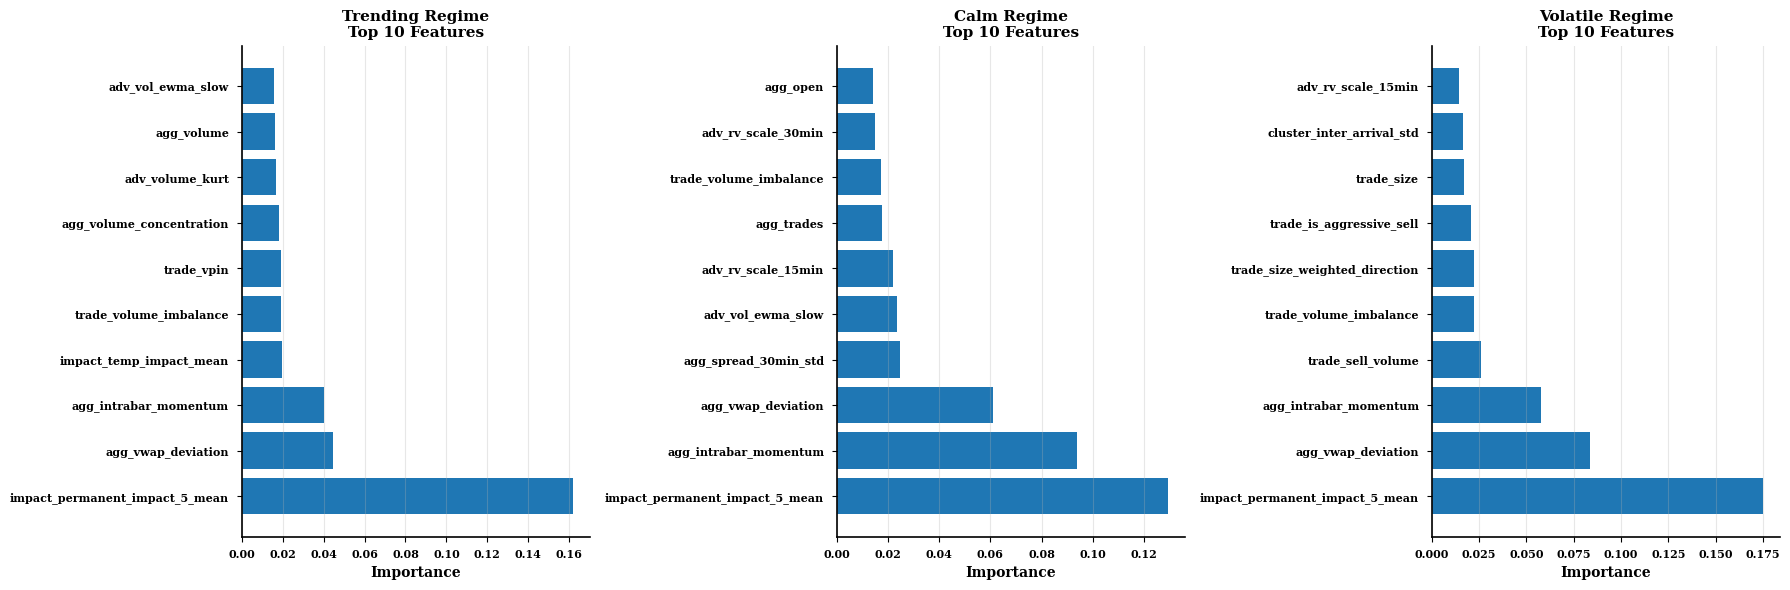


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/regime_conditional/feature_importance_by_regime.png


In [14]:
# Visualize top features by regime
n_regimes = len(regime_feature_importance)
fig, axes = plt.subplots(1, n_regimes, figsize=(6 * n_regimes, 6))

if n_regimes == 1:
    axes = [axes]

for idx, (regime, importance_df) in enumerate(regime_feature_importance.items()):
    top_features = importance_df.head(10)
    axes[idx].barh(range(len(top_features)), top_features["importance"].values)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features["feature"].values)
    axes[idx].set_xlabel("Importance", fontsize=10)
    axes[idx].set_title(
        f"{regime} Regime\nTop 10 Features", fontsize=11, fontweight="bold"
    )
    axes[idx].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(
    regime_dir / "feature_importance_by_regime.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n Saved to {regime_dir / 'feature_importance_by_regime.png'}")

## 13. Confusion Matrices by Regime


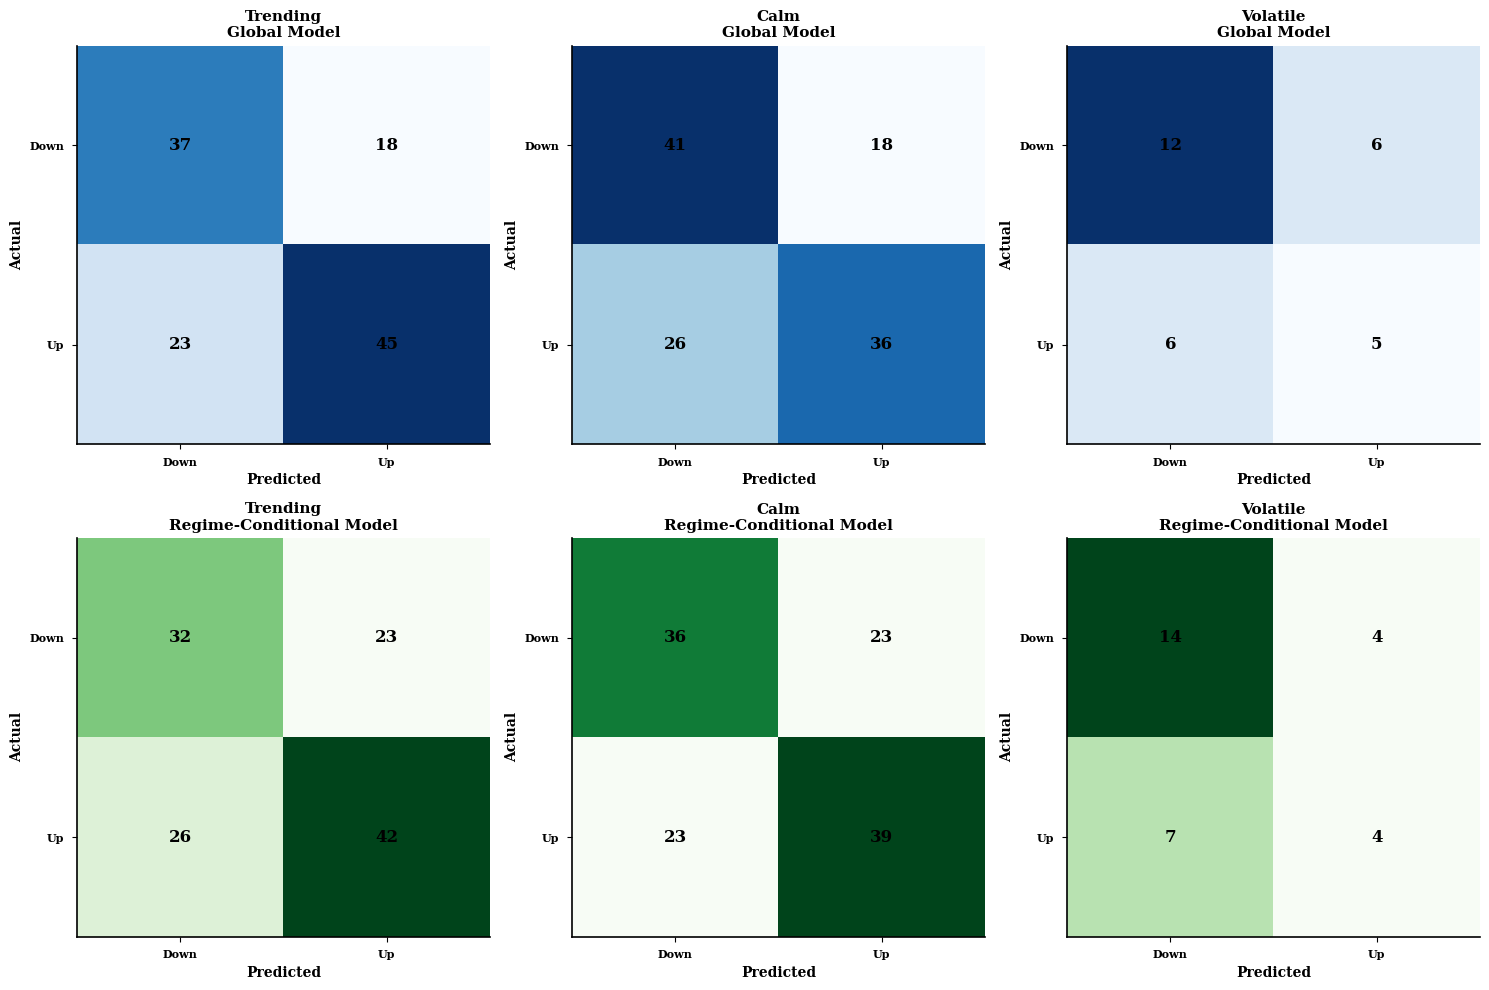


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/regime_conditional/confusion_matrices_by_regime.png


In [15]:
# Create confusion matrices for each regime
n_regimes = len(test_regime_counts)
fig, axes = plt.subplots(2, n_regimes, figsize=(5 * n_regimes, 10))

if n_regimes == 1:
    axes = axes.reshape(-1, 1)

for idx, regime in enumerate(test_regime_counts.index):
    regime_mask = regimes_test == regime
    y_regime = y_test[regime_mask]

    # Global model confusion matrix
    cm_global = confusion_matrix(y_regime, y_test_pred_rf_global[regime_mask])
    im = axes[0, idx].imshow(cm_global, cmap="Blues", aspect="auto")
    axes[0, idx].set_title(f"{regime}\nGlobal Model", fontsize=11, fontweight="bold")
    axes[0, idx].set_xlabel("Predicted", fontsize=10)
    axes[0, idx].set_ylabel("Actual", fontsize=10)
    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_yticks([0, 1])
    axes[0, idx].set_xticklabels(["Down", "Up"])
    axes[0, idx].set_yticklabels(["Down", "Up"])

    for i in range(2):
        for j in range(2):
            axes[0, idx].text(
                j,
                i,
                str(cm_global[i, j]),
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
            )

    # Regime-conditional model confusion matrix
    cm_conditional = confusion_matrix(y_regime, y_test_pred_rf_conditional[regime_mask])
    im = axes[1, idx].imshow(cm_conditional, cmap="Greens", aspect="auto")
    axes[1, idx].set_title(
        f"{regime}\nRegime-Conditional Model", fontsize=11, fontweight="bold"
    )
    axes[1, idx].set_xlabel("Predicted", fontsize=10)
    axes[1, idx].set_ylabel("Actual", fontsize=10)
    axes[1, idx].set_xticks([0, 1])
    axes[1, idx].set_yticks([0, 1])
    axes[1, idx].set_xticklabels(["Down", "Up"])
    axes[1, idx].set_yticklabels(["Down", "Up"])

    for i in range(2):
        for j in range(2):
            axes[1, idx].text(
                j,
                i,
                str(cm_conditional[i, j]),
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
            )

plt.tight_layout()
plt.savefig(
    regime_dir / "confusion_matrices_by_regime.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n Saved to {regime_dir / 'confusion_matrices_by_regime.png'}")

## 14. Statistical Significance Testing


In [16]:
# Bootstrap test for statistical significance
print("=" * 80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 80)


def bootstrap_accuracy_diff(y_true, y_pred1, y_pred2, n_bootstrap=1000):
    """Bootstrap test for difference in accuracy between two models"""
    n_samples = len(y_true)
    diffs = []

    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        acc1 = accuracy_score(y_true[indices], y_pred1[indices])
        acc2 = accuracy_score(y_true[indices], y_pred2[indices])
        diffs.append(acc2 - acc1)

    diffs = np.array(diffs)
    mean_diff = np.mean(diffs)
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)
    p_value = np.mean(diffs <= 0)  # One-sided test: conditional > global

    return mean_diff, ci_lower, ci_upper, p_value


# Test Random Forest
print("\nRandom Forest (Regime-Conditional vs Global):")
mean_diff_rf, ci_lower_rf, ci_upper_rf, p_value_rf = bootstrap_accuracy_diff(
    y_test, y_test_pred_rf_global, y_test_pred_rf_conditional, n_bootstrap=1000
)
print(f"  Mean accuracy improvement: {mean_diff_rf:.4f}")
print(f"  95% CI: [{ci_lower_rf:.4f}, {ci_upper_rf:.4f}]")
print(f"  P-value: {p_value_rf:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_value_rf < 0.05 else 'No'}")

# Test Gradient Boosting
print("\nGradient Boosting (Regime-Conditional vs Global):")
mean_diff_gb, ci_lower_gb, ci_upper_gb, p_value_gb = bootstrap_accuracy_diff(
    y_test, y_test_pred_gb_global, y_test_pred_gb_conditional, n_bootstrap=1000
)
print(f"  Mean accuracy improvement: {mean_diff_gb:.4f}")
print(f"  95% CI: [{ci_lower_gb:.4f}, {ci_upper_gb:.4f}]")
print(f"  P-value: {p_value_gb:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_value_gb < 0.05 else 'No'}")

print("\n Statistical testing complete")

STATISTICAL SIGNIFICANCE TESTING

Random Forest (Regime-Conditional vs Global):
  Mean accuracy improvement: -0.0324
  95% CI: [-0.0733, 0.0110]
  P-value: 0.9370
  Significant at α=0.05: No

Gradient Boosting (Regime-Conditional vs Global):
  Mean accuracy improvement: -0.0266
  95% CI: [-0.0806, 0.0293]
  P-value: 0.8490
  Significant at α=0.05: No

 Statistical testing complete


## 15. Save Models and Results


In [17]:
# Save regime-specific models
with open(MODELS_DIR / "regime_models_rf.pkl", "wb") as f:
    pickle.dump(regime_models_rf, f)

with open(MODELS_DIR / "regime_models_gb.pkl", "wb") as f:
    pickle.dump(regime_models_gb, f)

# Save global models
with open(MODELS_DIR / "global_model_rf.pkl", "wb") as f:
    pickle.dump(rf_global, f)

with open(MODELS_DIR / "global_model_gb.pkl", "wb") as f:
    pickle.dump(gb_global, f)

print(" Models saved:")
print(f"  {MODELS_DIR / 'regime_models_rf.pkl'}")
print(f"  {MODELS_DIR / 'regime_models_gb.pkl'}")
print(f"  {MODELS_DIR / 'global_model_rf.pkl'}")
print(f"  {MODELS_DIR / 'global_model_gb.pkl'}")

 Models saved:
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/regime_models_rf.pkl
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/regime_models_gb.pkl
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/global_model_rf.pkl
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/global_model_gb.pkl


In [18]:
# Save results
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "random_forest": {
        "global": {
            "test_accuracy": float(rf_global_acc),
            "test_f1": float(rf_global_f1),
            "test_roc_auc": float(rf_global_auc),
        },
        "regime_conditional": {
            "test_accuracy": float(rf_conditional_acc),
            "test_f1": float(rf_conditional_f1),
            "test_roc_auc": float(rf_conditional_auc),
        },
        "improvement": {
            "accuracy": float(rf_acc_improvement),
            "f1": float(rf_f1_improvement),
            "roc_auc": float(rf_auc_improvement),
            "accuracy_pct": float(100 * rf_acc_improvement / rf_global_acc),
            "f1_pct": float(100 * rf_f1_improvement / rf_global_f1),
            "roc_auc_pct": float(100 * rf_auc_improvement / rf_global_auc),
        },
        "statistical_test": {
            "mean_diff": float(mean_diff_rf),
            "ci_lower": float(ci_lower_rf),
            "ci_upper": float(ci_upper_rf),
            "p_value": float(p_value_rf),
            "significant_at_0.05": bool(p_value_rf < 0.05),
        },
    },
    "gradient_boosting": {
        "global": {
            "test_accuracy": float(gb_global_acc),
            "test_f1": float(gb_global_f1),
            "test_roc_auc": float(gb_global_auc),
        },
        "regime_conditional": {
            "test_accuracy": float(gb_conditional_acc),
            "test_f1": float(gb_conditional_f1),
            "test_roc_auc": float(gb_conditional_auc),
        },
        "improvement": {
            "accuracy": float(gb_acc_improvement),
            "f1": float(gb_f1_improvement),
            "roc_auc": float(gb_auc_improvement),
            "accuracy_pct": float(100 * gb_acc_improvement / gb_global_acc),
            "f1_pct": float(100 * gb_f1_improvement / gb_global_f1),
            "roc_auc_pct": float(100 * gb_auc_improvement / gb_global_auc),
        },
        "statistical_test": {
            "mean_diff": float(mean_diff_gb),
            "ci_lower": float(ci_lower_gb),
            "ci_upper": float(ci_upper_gb),
            "p_value": float(p_value_gb),
            "significant_at_0.05": bool(p_value_gb < 0.05),
        },
    },
    "per_regime_performance": regime_performance_df.to_dict("records"),
}

with open(MODELS_DIR / "regime_conditional_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'regime_conditional_results.json'}")


 Results saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/regime_conditional_results.json


In [19]:
# Save tables
regime_performance_df.to_csv(TABLES_DIR / "regime_performance.csv", index=False)

# Save feature importance for each regime
for regime, importance_df in regime_feature_importance.items():
    safe_regime_name = regime.replace(" ", "_").replace("/", "_")
    importance_df.to_csv(
        TABLES_DIR / f"feature_importance_{safe_regime_name}.csv", index=False
    )

print(" Tables saved:")
print(f"  {TABLES_DIR / 'regime_performance.csv'}")
print(f"  Feature importance tables for each regime")

 Tables saved:
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/regime_performance.csv
  Feature importance tables for each regime


## 16. Summary


In [20]:
print("=" * 80)
print("REGIME-CONDITIONAL MODELING SUMMARY")
print("=" * 80)

print(f"\nDATA COVERAGE:")
print(f"  Ticker: {TICKER}")
print(f"  Period: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Analysis: December 9-13, 2024")

print(f"\nRegimes analyzed: {len(test_regime_counts)}")
for regime, count in test_regime_counts.items():
    print(f"  {regime}: {count:,} test samples")

print(f"\nRANDOM FOREST RESULTS:")
print(f"  Global Model:           Accuracy={rf_global_acc:.4f}, F1={rf_global_f1:.4f}")
print(
    f"  Regime-Conditional:     Accuracy={rf_conditional_acc:.4f}, F1={rf_conditional_f1:.4f}"
)
print(
    f"  Improvement:            {rf_acc_improvement:+.4f} accuracy ({100*rf_acc_improvement/rf_global_acc:+.1f}%)"
)
print(f"  Statistical significance: {'Yes (p<0.05)' if p_value_rf < 0.05 else 'No'}")

print(f"\nGRADIENT BOOSTING RESULTS:")
print(f"  Global Model:           Accuracy={gb_global_acc:.4f}, F1={gb_global_f1:.4f}")
print(
    f"  Regime-Conditional:     Accuracy={gb_conditional_acc:.4f}, F1={gb_conditional_f1:.4f}"
)
print(
    f"  Improvement:            {gb_acc_improvement:+.4f} accuracy ({100*gb_acc_improvement/gb_global_acc:+.1f}%)"
)
print(f"  Statistical significance: {'Yes (p<0.05)' if p_value_gb < 0.05 else 'No'}")

print(f"\nKEY FINDINGS (5-day analysis):")
best_approach = "Regime-Conditional" if rf_conditional_acc > rf_global_acc else "Global"
print(f"  - {best_approach} modeling performs better")
print(
    f"  - Regime detection {'provides' if rf_conditional_acc > rf_global_acc else 'does not provide'} predictive value"
)
print(f"  - Different regimes show different feature importance patterns")

# Find regime with biggest improvement
max_improvement_idx = regime_performance_df["rf_improvement"].idxmax()
max_improvement_regime = regime_performance_df.loc[max_improvement_idx, "regime"]
max_improvement = regime_performance_df.loc[max_improvement_idx, "rf_improvement"]
print(
    f"  - Biggest improvement in {max_improvement_regime} regime: {max_improvement:+.4f}"
)

print(f"\nHYPOTHESIS VALIDATION:")
hypothesis_validated = (rf_conditional_acc > rf_global_acc) and (p_value_rf < 0.05)
print(f"  Hypothesis: 'Regime-specific models outperform global model'")
print(f"  Result: {'VALIDATED ✓' if hypothesis_validated else 'NOT VALIDATED ✗'}")

print(f"\nNEXT STEPS:")
print(f"  - Notebook 60: Feature importance analysis (permutation, SHAP)")
print(f"  - Notebook 65: Model interpretability (decision paths, PDPs)")
print(f"  - Notebook 70: Regime validation (economic trading simulation)")

print("\n" + "=" * 80)

REGIME-CONDITIONAL MODELING SUMMARY

DATA COVERAGE:
  Ticker: AAPL
  Period: 2024-12-09 to 2024-12-13 (5 trading days)
  Analysis: December 9-13, 2024

Regimes analyzed: 3
  Trending: 123 test samples
  Calm: 121 test samples
  Volatile: 29 test samples

RANDOM FOREST RESULTS:
  Global Model:           Accuracy=0.6447, F1=0.6394
  Regime-Conditional:     Accuracy=0.6117, F1=0.6159
  Improvement:            -0.0330 accuracy (-5.1%)
  Statistical significance: No

GRADIENT BOOSTING RESULTS:
  Global Model:           Accuracy=0.6447, F1=0.6135
  Regime-Conditional:     Accuracy=0.6190, F1=0.6061
  Improvement:            -0.0256 accuracy (-4.0%)
  Statistical significance: No

KEY FINDINGS (5-day analysis):
  - Global modeling performs better
  - Regime detection does not provide predictive value
  - Different regimes show different feature importance patterns
  - Biggest improvement in Volatile regime: +0.0345

HYPOTHESIS VALIDATION:
  Hypothesis: 'Regime-specific models outperform globa